In [1]:
# import utility libraries
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
%matplotlib inline

# import machine learning tools
# from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Graph
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from sklearn.metrics import roc_auc_score, accuracy_score

from clustering import Location_Clusterer, plot_list_in_2D

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN not available)


In [2]:
n = 8

In [3]:
folder = '/home/ubuntu/dataset/'
files = ['veg.nc', 'ppt.monthly.mask.nc', 'tmean.monthly.mask.nc', 'elev.nc']
var_names = ['Cv', 'Band1', 'Band1', 'elev']

lc = Location_Clusterer(n_clusters=n)
for f, var in zip(files, var_names):
    lc.read_data(folder+f, var)

lc.transform_data()
clusters = lc.fit_predict(lc.data2d)

#plot_list_in_2D(lc.coords2d[:,0], lc.coords2d[:,1], clusters)

In [4]:
# for i in xrange(n):
#     ind = (clusters==i)
#     plot_list_in_2D(lc.coords2d[:,0][ind], lc.coords2d[:,1][ind], clusters[ind])

In [5]:
%%writefile nn_input.py
# import utility libraries
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from collections import OrderedDict

# import machine learning tools
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import backend as K

# import utilities and classes I wrote
from clustering import Location_Clusterer

class NN_Input(object):
    """
    Stores the input data ready for feeding into a Keras neural network. 

    To-Do:
    - add function to take the clustering data in some ways
    - add function to return the actual lat, lon, and time based on indices
    
    """
    def __init__(self, predict=2, history=2, box=5, random_seed=None):
        """
        Initialize a class for storing neural network input data. 
        
        Parameters
        ----------
        predict: int, number of time points ahead that the model will predict. 
                 For example, if predict=2, the model will predict 2 time points away from the given time. 
        history: int, number of time points for which data would be included as input.
                 For example, if data_length=3, the model will receive 3 time points worth of data (current time
                 point, the previous time point, and the timep point before that).
        """
        if random_seed is not None:
            np.random.seed(random_seed)
        self.lons = None
        self.lats = None
        self.times = None
        
        self.labels = None
        self.features = {}
        self.feature_types = {}
        self.variables = []
        
        self.predict = predict
        self.history = history
        self.box = box
        
    def load_labels(self, f_path, var):
        """
        Load labels from netCDF file. 
        
        Parameters
        ----------
        f_path: string
        var: string
        """
        nc = Dataset(f_path, 'r')
        self.lons = nc.variables['lon'][:]
        self.lats = nc.variables['lat'][:]
        
        self.times = nc.variables['time'][self.history:-self.predict]
        n = self.predict + self.history
        self.labels = nc.variables[var][n:,:,:]
        
    def load_features(self, f_path, var, name, feature_type):
        """
        Load feature values from netCDF files. Stores feature type information. 
        
        Parameters
        ----------
        f_path: string, path to input netCDF file.
        var: string, variable name as appeared in the netCDF file. 
        name: string, name of the variable to be stored. 
        feature_type: string, must be one of the following: 'history_time_series', 'forecast_time_series', 
        'multi_layers', 'single_layer'
        """
        nc = Dataset(f_path, 'r')
        temp_data = nc.variables[var][:]
        
        # Storing information on whether the input features 
        self.feature_types[name] = feature_type
        self.variables.append(name)
        
        if self.feature_types[name] == 'history_time_series':
            self.features[name] = temp_data[:-self.predict, :, :]
        elif self.feature_types[name] == 'forecast_time_series':
            self.features[name] = temp_data[self.history:, :, :]
        else:
            self.features[name] = temp_data
        
    def get_batch(self, j, k):
        pass
    
    def get_features(self, i, j, k):
        """
        Given indices for latitude, longitude, and time point, returns the associated data from self.data. 
        
        Parameters
        ----------
        lat: int, index for the latitude desired. Must be within the range available in self.data. 
        lon: int, index for the longitude desired. Must be within the range available in self.data. 
        time: int, index for the time point desired. Must be within the range available in self.data. 
        """
        maps = None
#         lst = None
        for ix, feat in enumerate(self.variables):
            if self.feature_types[feat] == 'history_time_series':
                temp_data = self.features[feat][i:i+self.history+1, j-self.box:j+self.box+1, k-self.box:k+self.box+1]
            elif self.feature_types[feat] == 'forecast_time_series':
                temp_data = self.features[feat][i:i+self.predict+1, j-self.box:j+self.box+1, k-self.box:k+self.box+1]
#             elif self.feature_types[feat] == 'multi_layers':
#                 temp_data = self.features[feat][:, j, k].flatten()
#             else: 
#                 temp_data = self.features[feat][j, k]
            
            if len(temp_data.shape) == 3:                
                if np.sum(temp_data.mask) > len(temp_data.flatten())/2:
                    return None
                elif np.any(temp_data.mask):
                    temp_data = temp_data.filled(-999)
                    
                if maps is None:
                    maps = temp_data
                else:
                    maps = np.ma.concatenate((maps, temp_data), axis=0)
#             else:
#                 if lst is None:
#                     lst = temp_data
#                 else:
#                     lst = np.append(lst, temp_data)
#         return [maps, lst]
        return maps
        
    def select(self, n=None, t=None, cutoff=None, subset=None):
        """
        Selecting n data points randomly from the database before specified time cutoff. 
        
        Parameters
        ----------
        n: int, number of data points wanted. 
        cutoff: int, time cutoff for the training dataset. Default is half of the data available. 
        """
        if cutoff is None:
            cutoff = len(self.times)/2
        
        indices, labels, output_maps, output_lst = [], [], [], []
        
        mi = 0
        for ix, feat in enumerate(self.variables):
            if self.feature_types[feat] == 'history_time_series':
                mi += (self.history+1)
            elif self.feature_types[feat] == 'forecast_time_series':
                mi += (self.predict+1)
                
        map_dimensions = (mi, (2*self.box)+1, (2*self.box)+1)

        if n is None and t is None:
            for i in xrange(cutoff):
                for (k, j) in subset:
                    l = self.labels[i, j, k]
                    features = self.get_features(i, j, k)
                    if features is not None and l != np.nan and features.shape==map_dimensions:
                        indices.append([i, j, k])
                        labels.append(l)
                        output_maps.append(features)
#                         output_lst.append(features[1])
        
        elif t is not None:
            for (k, j) in subset:
                l = self.labels[t, j, k]
                features = self.get_features(t, j, k)
                if features is not None and l != np.nan and features.shape==map_dimensions:
                    indices.append([t, j, k])
                    labels.append(l)
                    output_maps.append(features)
#                     output_lst.append(features[1])
        
        else:
            while len(labels) < n:
                if subset is not None:
                    (k, j) = subset[np.random.choice(len(subset))]
                else:
                    j = np.random.randint(self.box, len(self.lats)-self.box)
                    k = np.random.randint(self.box, len(self.lons)-self.box)
                i = np.random.randint(cutoff)
                l = self.labels[i, j, k]
                features = self.get_features(i, j, k)
                if features is not None and l != np.nan and features.shape==map_dimensions:
                    indices.append([i, j, k])
                    labels.append(l)
                    output_maps.append(features)
#                     output_lst.append(features[1])
                    
        return np.array(indices), np.array(labels), np.array(output_maps)


Overwriting nn_input.py


In [6]:
def reformat_y(y):
    y[y == -1] = 0
    y = np.hstack((y.reshape(-1,1), 1-y.reshape(-1,1)))
    return y

In [7]:
from nn_input import NN_Input

nn = NN_Input(predict=2, history=5, box=5, random_seed=42)
nn.load_labels(folder+'sign.label.nc', 'Band1')

# f_paths = ['all.ndvi.nc','all.max.of.Wind.nc', 'all.min.of.Tmin.nc', 'all.mean.of.Tmin.nc', 'all.sum.of.Prec.nc',
#            'all.max.of.Tmax.nc', 'all.mean.of.Tmax.nc','elev.nc', 'veg.nc']
# variables = ['Band1', 'Wind', 'Tmin', 'Tmin', 'Prec', 'Tmax', 'Tmax', 'elev', 'Cv']
# names = ['ndvi', 'max_wind', 'min_tmin', 'mean_tmin', 'total_prec', 'max_tmax', 'mean_tmax', 'elev', 'veg']
# feature_types = ['history_time_series', 'forecast_time_series', 'forecast_time_series', 'forecast_time_series',
#                  'forecast_time_series', 'forecast_time_series', 'forecast_time_series',
#                 'single_layer', 'multi_layers']

f_paths = ['all.mean.of.Tmin.nc', 'all.mean.of.Tmin.nc']
variables = ['Tmin', 'Tmin']
names = ['mean_tmin_history', 'mean_tmin_forecast']
feature_types = ['history_time_series', 'forecast_time_series']

for f_path, v, n, feature_type in zip(f_paths, variables, names, feature_types):
    nn.load_features(folder+f_path, v, n, feature_type)


In [8]:
point = [308, 290]
for i, loc in enumerate(lc.ind2d):
    if loc[0] == point[0] and loc[1] == point[1]:
        cluster = clusters[i]

print 'Modeling for cluster', cluster
subset = lc.ind2d[clusters==cluster]

print 'Getting training dataset'
id_train, y_train, X_map_train = nn.select(n=100000, subset=subset)
y_train = reformat_y(y_train)

Modeling for cluster 6
Getting training dataset


In [9]:
print 'Getting test dataset'

t = (len(nn.times)/2) +1
print len(subset)
id_test, y_test, X_map_test = nn.select(t=t, subset=subset)
y_test = reformat_y(y_test)
print len(y_test)

Getting test dataset
17864
15886


In [10]:
map_dimensions=X_map_train[0].shape
print map_dimensions
print np.all(X_map_train[0] == X_map_train[1])

std = np.max(X_map_train)
X_map_train = X_map_train/std
X_map_test = X_map_test/std
print y_train.shape

(9, 11, 11)
False
(100000, 2)


In [ ]:
def build_base_sequential_NN(n_conv_layers=2, nb_filters=16, nb_conv=3, map_dimensions=None, nb_pool=2):

    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=map_dimensions))
    
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    sgd = SGD()
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = build_base_sequential_NN(nb_filters=64, map_dimensions=map_dimensions)
model.fit(X_map_train, y_train, batch_size=50, nb_epoch=5, verbose=True, validation_data=(X_map_test, y_test))
train_predict = model.predict(X_map_train, verbose=True)
test_predict = model.predict(X_map_test, verbose=True)

Train on 100000 samples, validate on 15886 samples
Epoch 1/5
100000/100000 [==============================] - 35s - loss: 0.6529 - acc: 0.8358 - val_loss: 0.6150 - val_acc: 0.7242
Epoch 2/5
100000/100000 [==============================] - 35s - loss: 0.3196 - acc: 0.8823 - val_loss: 0.6699 - val_acc: 0.6896
Epoch 3/5
100000/100000 [==============================] - 35s - loss: 0.2739 - acc: 0.8996 - val_loss: 0.5889 - val_acc: 0.7422
Epoch 4/5
100000/100000 [==============================] - 35s - loss: 0.2553 - acc: 0.9075 - val_loss: 0.7300 - val_acc: 0.6745
Epoch 5/5
15886/15886 [==============================] - 2s     


In [ ]:
threshold = 0.5

print 'Training set:'
print 'Bench mark:', np.sum(y_train[:,1])/float(len(y_train))
print 'Accuracy:', accuracy_score(y_train[:,0], (train_predict[:,0]>threshold))
print 'ROC AUC:', roc_auc_score(y_train[:,0], train_predict[:,0])
print 
print 'Testing set:'
print 'Bench mark:', np.sum(y_test[:,1])/float(len(y_test))
print 'Accuracy:', accuracy_score(y_test[:,0], (test_predict[:,0]>threshold))
print 'ROC AUC:', roc_auc_score(y_test[:,0], test_predict[:,0])

Training set:
Bench mark: 0.65549
Accuracy: 0.9103
ROC AUC: 0.952366300716

Testing set:
Bench mark: 0.763250660959
Accuracy: 0.751919929498
ROC AUC: 0.660984372987


In [ ]:
def plot_compare_map(lons, lats, y_true, y_predict, cmap=None):
    if cmap=None:
        cmap=mpl.cm.get_cmap('BrBG')
        
    norm = mpl.colors.Normalize(y_true.min, y_true.max)
    area_thresh=25000
    land_color='grey'
    ocean_color='lightblue'

    fig = plt.figure(figsize=(20,12))

    ax = fig.add_subplot(1,1,1)
    m = Basemap(projection='cyl', llcrnrlat=lats.min(), llcrnrlon=lons.min(),
            urcrnrlat=lats.max(), urcrnrlon=lons.max(), resolution='h',
            area_thresh=area_thresh)
    xi, yi = m(lons, lats)
    xi, yi = np.meshgrid(xi, yi)
    m.pcolormesh(lons, lats, var, cmap=cmap, norm=norm)
    m.scatter(lons, lats, var, cmap=cmap, norm=norm)
    m.drawlsmask(land_color=land_color, ocean_color=ocean_color, lakes=True)
    m.drawcountries()
    m.drawcoastlines()

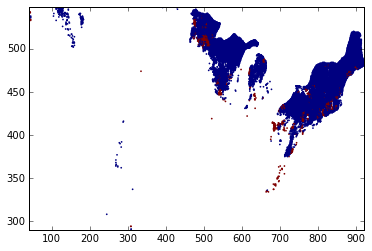

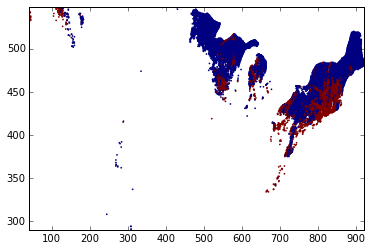

In [ ]:
print 'Getting test dataset'

for t in xrange(216, 230):

    id_test, y_test, X_map_test = nn.select(t=t, subset=subset)
    y_test = reformat_y(y_test)
    X_map_test = X_map_test/std

    xs = id_test[:,2]
    ys = id_test[:,1]

    test_predict = model.predict(X_map_test, verbose=True)
    
    plt.figure(figsize())
    Basemap
    m.scatter
    plot_list_in_2D(xs, ys, (test_predict[:,0]>threshold))
    plot_list_in_2D(xs, ys, y_test[:,0])

In [ ]:
set(nn.lats)

In [14]:
# # # graph model with two inputs and one output 
# # graph = Graph() 
# # graph.add_input(name='input1', input_shape=(32,)) 
# # graph.add_input(name='input2', input_shape=(32,)) 
# # graph.add_node(Dense(16), name='dense1', input='input1') 
# # graph.add_node(Dense(4), name='dense2', input='input2') 
# # graph.add_node(Dense(4), name='dense3', input='dense1') 

# # graph.add_output(name='output', inputs=['dense2', 'dense3'], merge_mode='sum') 

# # graph.compile(optimizer='rmsprop', loss={'output':'mse'}) 
# # history = graph.fit({'input1':X_train, 'input2':X2_train, 'output':y_train}, nb_epoch=10) 
# # predictions = graph.predict({'input1':X_test, 'input2':X2_test}) # {'output':...}


# # graph model with two inputs and one output 
# model = Graph() 

# map_dimensions=train_X_map[0][0].shape

# # two types of inputs: maps in 3D matrix and a list
# model.add_input(name='maps', input_shape=train_X_map[0].shape) 
# model.add_input(name='lst', input_shape=train_X_lst[0].shape) 

# # adding layers to process the maps
# # 
# model.add_node(Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering='th')
#                , name='map_conv1', input='maps')
# # add pooling layers
# model.add_node(Flatten(), name='map_flatten', input='map_conv1')
# model.add_node(Dense(64), name='map_dense1', input='map_flatten')

# # adding layers to process the lst
# model.add_node(Dense(16), name='lst_dense1', input='lst') 
# model.add_node(Dense(8), name='lst_dense2', input='lst_dense1')

# # merging two sets of weights
# model.add_node(Dense(72, activation='relu'), name='combine', inputs=['map_flatten', 'lst_dense1'], merge_mode='concat')
# model.add_node(Dense(1, activation='sigmoid'), name='reduce', input='combine')
# model.add_output(name='output', input='reduce')

# sgd = SGD(lr=0.001)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

# # use dropouts 
# # try different solver
# # if acc = 0, network diverged, reduce step size

In [15]:
# model.fit({'maps': train_X_map, 'lst': train_X_lst, 'output': train_y}, nb_epoch=10, batch_size=10, verbose=True)

In [16]:
# prediction = model.predict({'maps': np.array(test_X_map), 'lst': np.array(test_X_lst)}, batch_size=1000)